In [1]:
import sys
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import requests, math, io, sys, cv2
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import random
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Creating a class to define SOM

class SOM(object):
    
    #To check if the SOM has been trained
    
    _trained = False

    def __init__(self, m, n, dim, n_iterations=10, alpha=None, sigma=None):
    
        """
 
        m X n : SOM dimensions
        n_iterations : number of iterations 
        dim : dimensionality of the training inputs
        alpha : learning rate (0.4 by deafault)
        sigma : initial neighbourhood value
        
        """
 
        #Assign required variables first
        self._m = m
        self._n = n
        if alpha is None:
            alpha = 0.4
        else:
            alpha = float(alpha)
        
        sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))
 
        #Initialize graph
        self._graph = tf.Graph()
 
        #Populate graph
        with self._graph.as_default():

            self._weightage_vects = tf.Variable(tf.random.normal([m*n, dim]))
            self._location_vects = tf.constant(np.array(list(self._neuron_locations(m, n))))
 
            #Declaring Placeholders
            #The training vector
            self._vect_input = tf.placeholder("float", [dim])
            #Iteration number
            self._iter_input = tf.placeholder("float")
 
            #Constructing Traning Algorithm

            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weightage_vects, tf.stack(
                    [self._vect_input for i in range(m*n)])), 2), 1)),
                                  0)
            
            slice_input = tf.pad(tf.reshape(bmu_index, [1]),np.array([[0, 1]]))
            
            bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input,
                                          tf.constant(np.array([1, 2]))),[2])
 
            #Updating values of alpha and sigma
            learning_rate_op = tf.subtract(1.0, tf.divide(self._iter_input,
                                                  self._n_iterations))
            _alpha_op = tf.multiply(alpha, learning_rate_op)
            _sigma_op = tf.multiply(sigma, learning_rate_op)
 
            #Genrate Learning rates based on location
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(self._location_vects, tf.stack([bmu_loc for i in range(m*n)])), 2), 1)
            
            neighbourhood_func = tf.exp(tf.negative(tf.divide(tf.cast(bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
            
            learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)
 
            #Update Neuron vectors
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(learning_rate_op, np.array([i]), np.array([1])), [dim]) for i in range(m*n)])
            
            weightage_delta = tf.multiply(learning_rate_multiplier, tf.subtract(tf.stack([self._vect_input for i in range(m*n)]), self._weightage_vects))                                         
            
            new_weightages_op = tf.add(self._weightage_vects, weightage_delta)

            self._training_op = tf.assign(self._weightage_vects, new_weightages_op)                                       
 
            self._sess = tf.Session()
 
            init_op = tf.global_variables_initializer()

            self._sess.run(init_op)
 
    def _neuron_locations(self, m, n):
        # gives 2-d individual location of neurons in SOM

        for i in range(m):
            for j in range(n):
                yield np.array([i, j])
 
    def train(self, input_vects):
        
        # training SOM
 
        for iter_no in range(self._n_iterations):
            for input_vect in input_vects:
                self._sess.run(self._training_op, feed_dict={self._vect_input: input_vect, self._iter_input: iter_no})
 
        #storing a centroid grid 
        centroid_grid = [[] for i in range(self._m)]

        self._weightages = list(self._sess.run(self._weightage_vects))
        self._locations = list(self._sess.run(self._location_vects))
        
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._weightages[i])
        
        self._centroid_grid = centroid_grid
 
        self._trained = True
 
    def get_centroids(self):
        
        # to get centroid lists

        if not self._trained:
            raise ValueError("SOM not trained yet")
        return self._centroid_grid
 
    def map_vects(self, input_vects):
        
        # mapping each input vector to the relevant neuron in the SOM grid.

        if not self._trained:
            raise ValueError("SOM not trained yet")
 
        to_return = []

        for vect in input_vects:
            
            min_index = min([i for i in range(len(self._weightages))], key=lambda x: np.linalg.norm(vect-self._weightages[x]))

            to_return.append(self._locations[min_index])
 
        return to_return


In [4]:
 def download_image(url): 
    
    #Method for downloading image, scaling the resolution and converting into numpy array
    
    try:
        r = requests.get(url, stream=True)
    except:
        print('Error in loading image')
        print(sys.exc_info()[0])
        return None
    
    try:
        i_temp = Image.open(io.BytesIO(r.content))
        img = np.asarray(i_temp.convert('L'))

    except:
        print('Failed to parse image')
        print(sys.exc_info()[0])
        return None
    
    return img

# Trains a SOM on the given data and returns it
def som_plot(img, som_dims, dim_b, num_iter, alpha, sigma): 

    # Select small amount of random pixels from the image. 
    n_pixels = 500
    
    colors = shuffle(img.reshape((img.shape[0]*img.shape[1], dim_b)))[:n_pixels]
    
    # Train the SOM model with small amount of iterations. 
    som = SOM(som_dims[0], som_dims[1], dim_b, num_iter, alpha, sigma)
    som.train(colors)
    outp = img.reshape((img.shape[0]*img.shape[1], dim_b))

    #Get output grid from the SOM. 
    image_grid = som.get_centroids()
    mapping = som.map_vects(outp)
    return(image_grid,mapping)

In [5]:
def get_img_arr(dim_m=512, dim_n=512, dim_b=31, git_url='https://github.com/Zitishk/KSOM/blob/main/watercolors_ms_'):
    
    arrays1 = np.zeros((dim_m, dim_n, dim_b))
    for i in range(dim_b):

        mystr1 = git_url
        mystr2 = '.png?raw=True'
        
        a = str(int((i+1)/10))
        b = str((i+1)%10)
        
        mystr = mystr1 + a + b + mystr2
        
        img = download_image(mystr)
        
        for j1 in range(dim_m):
            for j2 in range(dim_n):
                arrays1[j1][j2][i]=img[j1][j2]
    
    return arrays1

In [12]:
def show_heatmaps(som_op_x=10, som_op_y=10, dim_m=512, dim_n=512, dim_b=31, num_iter=50, alpha=0.4, sigma=5, git_url='https://github.com/Zitishk/KSOM/blob/main/watercolors_ms_'):

    Som_size = [som_op_x,som_op_y]

    arr = get_img_arr(dim_m, dim_n, dim_b, git_url)
    
    grd,mapping = som_plot(arr, Som_size, dim_b, num_iter, alpha, sigma)
    
    arr1=np.zeros((Som_size[0]*Som_size[1],31))
    for i in range(31):
        for j in range(Som_size[0]):
            for k in range(Som_size[1]):
                arr1[Som_size[0]*j+k][i]=grd[j][k][i]
    kmeans = KMeans(n_clusters=10, random_state=0).fit(arr1)
    labels = kmeans.predict(arr1)
    clustered_som = np.reshape(labels,(Som_size[0],Som_size[1]))
    final = np.zeros(len(mapping))
    for i in range(len(mapping)):
        final[i] = clustered_som[mapping[i][0]][mapping[i][1]]
    output = np.reshape(final,(dim_m,dim_n))
    img=plt.imshow(output)
    plt.show()

In [13]:
def run_implementation():
    ins = int(input())
    if(ins==0):
        show_heatmaps()
    else:
        ip_n = int(input("Input Dimension n : "))
        ip_m = int(input("Input Dimension m : "))
        op_m = int(input("Output Dimension m : "))
        op_n = int(input("Output Dimension n : "))
        bands = int(input("Number of bands: "))
        iters = int(input("Number of iterations : "))
        lr = float(input("Learning Rate (initial) : "))
        init_sigma = float(input("Initial sigma value for neighbourhood function : "))
        git_url = input("Enter starting url of git for image input : ")

        show_heatmaps(op_m, op_n, ip_m, ip_n, bands, iters, lr, init_sigma, git_url)


0


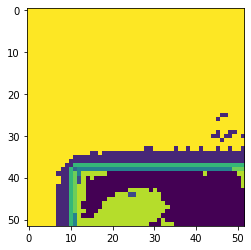

In [14]:
run_implementation()

In [ ]:
run_implementation()